In [1]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import svm, cross_validation, metrics, preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.externals import joblib
import seaborn as sb

client = pymongo.MongoClient()
db = client.VentDB
validData = db.train_collection

%matplotlib inline

In [2]:
validData.find({'validation':{'$exists':1}}).count()

1873

In [3]:
data = validData.find({'validation':{'$exists':1}}, {'validation':1, 'breath_character':1, 'breath_settings':1, 
                                                     'max_min_analysis':1, 'next_breath_data':1, '_id':0})
df = pd.io.json.json_normalize(list(data))

In [4]:
list(df.columns)

['breath_character.elapse_time',
 'breath_character.end_insp_flow',
 'breath_character.end_insp_paw',
 'breath_character.end_insp_time',
 'breath_character.end_insp_vol',
 'breath_character.end_time',
 'breath_character.exp_time',
 'breath_character.insp_time',
 'breath_character.mean_exp_flow',
 'breath_character.mean_exp_paw',
 'breath_character.mean_insp_flow',
 'breath_character.mean_insp_paw',
 'breath_character.min_exp_flow',
 'breath_character.min_exp_paw',
 'breath_character.min_exp_vol',
 'breath_character.min_flow',
 'breath_character.min_paw',
 'breath_character.min_vol',
 'breath_character.n_dF/dP_exp_max',
 'breath_character.n_dF/dP_insp_max',
 'breath_character.n_dF/dV_exp_max',
 'breath_character.n_dF/dV_insp_max',
 'breath_character.n_dP/dV_exp_max',
 'breath_character.n_dP/dV_insp_max',
 'breath_character.peak_flow',
 'breath_character.peak_paw',
 'breath_character.peak_vol',
 'breath_character.start_time',
 'breath_settings.auto_peep',
 'breath_settings.compliance',
 

In [5]:
df.replace({np.nan:0}, inplace=True)
df['breath_settings.vent_mode'] = df['breath_settings.vent_mode'].astype('category')

df = df[(df['breath_settings.vent_mode'] == 'APVCMV') | (df['breath_settings.vent_mode'] == 'PCMV')]
df.drop(['breath_settings.vent_mode', 'breath_settings.i:e', 'breath_settings.file'], inplace=True, axis=1)
df.shape

(1638, 186)

In [6]:
df = df[(df['breath_character.peak_vol'] < 2000) & (df['breath_character.peak_vol'] > 100) & (df['breath_character.elapse_time'] < 6000)]
df.shape

(1580, 186)

In [7]:
df['norm_predict'] = np.nan

In [32]:
col = {'norm': ['breath_character.elapse_time',
                 'breath_character.end_insp_flow',
                 'breath_character.end_insp_paw',
                 'breath_character.end_insp_vol',
                 'breath_character.exp_time',
                 'breath_character.insp_time',
                 'breath_character.mean_exp_flow',
                 'breath_character.mean_exp_paw',
                 'breath_character.mean_insp_flow',
                 'breath_character.mean_insp_paw',
                 'breath_character.min_exp_flow',
                 'breath_character.min_exp_paw',
                 'breath_character.min_exp_vol',
                 'breath_character.min_flow',
                 'breath_character.min_paw',
                 'breath_character.min_vol',
                 'breath_character.n_dF/dP_exp_max',
                 'breath_character.n_dF/dP_insp_max',
                 'breath_character.n_dF/dV_exp_max',
                 'breath_character.n_dF/dV_insp_max',
                 'breath_character.n_dP/dV_exp_max',
                 'breath_character.n_dP/dV_insp_max',
                 #'breath_character.peak_flow',
                 'breath_character.peak_paw',
                 'max_min_analysis.sm_flow.delta_insp_max',
                 'max_min_analysis.sm_flow.delta_insp_max_25',
                 'max_min_analysis.sm_flow.delta_insp_max_50',
                 'max_min_analysis.sm_flow.delta_insp_max_75',
                 'max_min_analysis.sm_flow.insp_25_max',
                 'max_min_analysis.sm_flow.insp_50_max',
                 'max_min_analysis.sm_flow.insp_75_max',
                 'max_min_analysis.sm_flow.insp_ptp_max_delta',
                 'max_min_analysis.sm_flow.insp_ptp_rel_position',
                 'max_min_analysis.sm_flow.insp_ptp_time_delta',
                 'max_min_analysis.sm_flow.insp_rise',
                 'max_min_analysis.sm_flow.insp_rise_25',
                 'max_min_analysis.sm_flow.insp_rise_50',
                 'max_min_analysis.sm_flow.insp_rise_75',
                 'max_min_analysis.sm_flow.n_exp_max',
                 'max_min_analysis.sm_flow.n_exp_max_15',
                 'max_min_analysis.sm_flow.n_exp_max_25',
                 'max_min_analysis.sm_flow.n_exp_max_50',
                 'max_min_analysis.sm_flow.n_exp_max_75',
                 'max_min_analysis.sm_flow.n_insp_max',
                 'max_min_analysis.sm_flow.n_insp_max_25',
                 'max_min_analysis.sm_flow.n_insp_max_50',
                 'max_min_analysis.sm_flow.n_insp_max_75',
                 'max_min_analysis.sm_flow.n_insp_max_90',
                 'max_min_analysis.sm_flow.n_insp_min',
                 'max_min_analysis.sm_flow.n_insp_min_25',
                 'max_min_analysis.sm_flow.n_insp_min_50',
                 'max_min_analysis.sm_flow.n_insp_min_75',
                 'max_min_analysis.sm_flow.shoulder_amp',
                 'max_min_analysis.sm_flow.shoulder_time',
                 'max_min_analysis.sm_flow.shoulder_time_percent',
                 'max_min_analysis.sm_paw.delta_insp_max',
                 'max_min_analysis.sm_paw.delta_insp_max_25',
                 'max_min_analysis.sm_paw.delta_insp_max_50',
                 'max_min_analysis.sm_paw.delta_insp_max_75',
                 'max_min_analysis.sm_paw.insp_25_max',
                 'max_min_analysis.sm_paw.insp_50_max',
                 'max_min_analysis.sm_paw.insp_75_max',
                 'max_min_analysis.sm_paw.insp_ptp_max_delta',
                 'max_min_analysis.sm_paw.insp_ptp_rel_position',
                 'max_min_analysis.sm_paw.insp_ptp_time_delta',
                 'max_min_analysis.sm_paw.insp_rise',
                 'max_min_analysis.sm_paw.insp_rise_25',
                 'max_min_analysis.sm_paw.insp_rise_50',
                 'max_min_analysis.sm_paw.insp_rise_75',
                 'max_min_analysis.sm_paw.n_exp_max',
                 'max_min_analysis.sm_paw.n_exp_max_15',
                 'max_min_analysis.sm_paw.n_exp_max_25',
                 'max_min_analysis.sm_paw.n_exp_max_50',
                 'max_min_analysis.sm_paw.n_exp_max_75',
                 'max_min_analysis.sm_paw.n_insp_max',
                 'max_min_analysis.sm_paw.n_insp_max_25',
                 'max_min_analysis.sm_paw.n_insp_max_50',
                 'max_min_analysis.sm_paw.n_insp_max_75',
                 'max_min_analysis.sm_paw.n_insp_max_90',
                 'max_min_analysis.sm_paw.n_insp_min',
                 'max_min_analysis.sm_paw.n_insp_min_25',
                 'max_min_analysis.sm_paw.n_insp_min_50',
                 'max_min_analysis.sm_paw.n_insp_min_75',
                 'max_min_analysis.sm_paw.shoulder_amp',
                 'max_min_analysis.sm_paw.shoulder_time',
                 'max_min_analysis.sm_paw.shoulder_time_percent'],

    'ds':  [ 'breath_character.insp_time',
                'breath_character.exp_time', 
                'breath_character.elapse_time', 
                'breath_character.min_exp_vol', 
                'breath_character.min_vol',
                'next_breath_data.min_exp_vol',
                ],

    'pfl':  [ 'norm_predict',
                 'breath_character.elapse_time',
                 'breath_character.end_insp_flow',
                 #'breath_character.end_insp_paw',
                 'breath_character.end_insp_vol',
                 #'breath_character.insp_time',
                 #'breath_character.mean_insp_flow',
                 #'breath_character.mean_insp_paw',
                 #'breath_character.min_flow',
                 #'breath_character.min_paw',
                 #'breath_character.min_vol',
                 #'breath_character.n_dF/dP_insp_max',
                 #'breath_character.n_dF/dV_insp_max',
                 #'breath_character.n_dP/dV_insp_max',
                 #'breath_character.peak_flow',
                 #'breath_character.peak_paw',
                 #'breath_character.peak_vol',
                 #'max_min_analysis.sm_flow.delta_insp_max',
                 #'max_min_analysis.sm_flow.delta_insp_max_25',
                 #'max_min_analysis.sm_flow.delta_insp_max_50',
                 #'max_min_analysis.sm_flow.delta_insp_max_75',
                 #'max_min_analysis.sm_flow.insp_25_max',
                 #'max_min_analysis.sm_flow.insp_50_max',
                 #'max_min_analysis.sm_flow.insp_75_max',
                 #'max_min_analysis.sm_flow.insp_ptp_max_delta',
                 #'max_min_analysis.sm_flow.insp_ptp_rel_position',
                 #'max_min_analysis.sm_flow.insp_ptp_time_delta',
                 #'max_min_analysis.sm_flow.insp_rise',
                 #'max_min_analysis.sm_flow.insp_rise_25',
                 #'max_min_analysis.sm_flow.insp_rise_50',
                 #'max_min_analysis.sm_flow.insp_rise_75',
                 'max_min_analysis.sm_flow.n_insp_max',
                 'max_min_analysis.sm_flow.n_insp_max_25',
                 'max_min_analysis.sm_flow.n_insp_max_50',
                 'max_min_analysis.sm_flow.n_insp_max_75',
                 'max_min_analysis.sm_flow.n_insp_max_90',
                 #'max_min_analysis.sm_flow.n_insp_min',
                 #'max_min_analysis.sm_flow.n_insp_min_25',
                 #'max_min_analysis.sm_flow.n_insp_min_50',
                 #'max_min_analysis.sm_flow.n_insp_min_75',
                 #'max_min_analysis.sm_flow.shoulder_amp',
                 #'max_min_analysis.sm_flow.shoulder_time',
                 'max_min_analysis.sm_flow.shoulder_time_percent',
                 #'max_min_analysis.sm_paw.delta_insp_max',
                 #'max_min_analysis.sm_paw.delta_insp_max_25',
                 #'max_min_analysis.sm_paw.delta_insp_max_50',
                 #'max_min_analysis.sm_paw.delta_insp_max_75',
                 'max_min_analysis.sm_paw.insp_25_max',
                 #'max_min_analysis.sm_paw.insp_50_max',
                 #'max_min_analysis.sm_paw.insp_75_max',
                 #'max_min_analysis.sm_paw.insp_ptp_max_delta',
                 #'max_min_analysis.sm_paw.insp_ptp_rel_position',
                 #'max_min_analysis.sm_paw.insp_ptp_time_delta',
                 'max_min_analysis.sm_paw.insp_rise',
                 'max_min_analysis.sm_paw.insp_rise_25',
                 'max_min_analysis.sm_paw.insp_rise_50',
                 'max_min_analysis.sm_paw.insp_rise_75',
                 'max_min_analysis.sm_paw.n_insp_max',
                 'max_min_analysis.sm_paw.n_insp_max_25',
                 'max_min_analysis.sm_paw.n_insp_max_50',
                 'max_min_analysis.sm_paw.n_insp_max_75',
                 'max_min_analysis.sm_paw.n_insp_max_90',
                 #'max_min_analysis.sm_paw.n_insp_min',
                 #'max_min_analysis.sm_paw.n_insp_min_25',
                 #'max_min_analysis.sm_paw.n_insp_min_50',
                 #'max_min_analysis.sm_paw.n_insp_min_75',
                 'max_min_analysis.sm_paw.shoulder_amp',
                 #'max_min_analysis.sm_paw.shoulder_time',
                 'max_min_analysis.sm_paw.shoulder_time_percent',
                 ],
        
    'pvt':  [ 'norm_predict',
                 'breath_character.elapse_time',
                 'breath_character.end_insp_flow',
                 #'breath_character.end_insp_paw',
                 #'breath_character.end_insp_vol',
                 'breath_character.exp_time',
                 #'breath_character.insp_time',
                 'breath_character.mean_exp_flow',
                 #'breath_character.mean_exp_paw',
                 #'breath_character.min_exp_flow',
                 'breath_character.min_exp_paw',
                 #'breath_character.min_exp_vol',
                 #'breath_character.min_flow',
                 #'breath_character.min_paw',
                 #'breath_character.min_vol',
                 #'breath_character.n_dF/dP_exp_max',
                 #'breath_character.n_dF/dV_exp_max',
                 #'breath_character.n_dP/dV_exp_max',
                 'max_min_analysis.sm_flow.n_exp_max',
                 'max_min_analysis.sm_flow.n_exp_max_15',
                 'max_min_analysis.sm_flow.n_exp_max_25',
                 'max_min_analysis.sm_paw.n_exp_max',
                 'max_min_analysis.sm_paw.n_exp_max_15',
                 'max_min_analysis.sm_paw.n_exp_max_25',
                 #'max_min_analysis.sm_vol.n_exp_max',
                 #'max_min_analysis.sm_vol.n_exp_max_15',
                 #'max_min_analysis.sm_vol.n_exp_max_25',
                ],

    'ie':  [  'norm_predict',
                 'breath_character.elapse_time',
                 'breath_character.end_insp_flow',
                 'breath_character.end_insp_paw',
                 'breath_character.end_insp_vol',
                 'breath_character.exp_time',
                 'breath_character.insp_time',
                 'breath_character.mean_exp_flow',
                 'breath_character.mean_exp_paw',
                 'breath_character.min_exp_flow',
                 'breath_character.min_exp_paw',
                 'breath_character.min_exp_vol',
                 'breath_character.min_flow',
                 'breath_character.min_paw',
                 'breath_character.min_vol',
                 'breath_character.n_dF/dP_exp_max',
                 'breath_character.n_dF/dV_exp_max',
                 'breath_character.n_dP/dV_exp_max',
                 'max_min_analysis.sm_flow.n_exp_max',
                 'max_min_analysis.sm_flow.n_exp_max_15',
                 'max_min_analysis.sm_flow.n_exp_max_25',
                 'max_min_analysis.sm_flow.n_exp_max_50',
                 'max_min_analysis.sm_flow.n_exp_max_75',
                 'max_min_analysis.sm_paw.n_exp_max',
                 'max_min_analysis.sm_paw.n_exp_max_15',
                 'max_min_analysis.sm_paw.n_exp_max_25',
                 'max_min_analysis.sm_paw.n_exp_max_50',
                 'max_min_analysis.sm_paw.n_exp_max_75',
                 'max_min_analysis.sm_vol.n_exp_max',
                 'max_min_analysis.sm_vol.n_exp_max_15',
                 'max_min_analysis.sm_vol.n_exp_max_25',
                 'max_min_analysis.sm_vol.n_exp_max_50',
                 'max_min_analysis.sm_vol.n_exp_max_75',
                ]
       }

In [33]:
use_norms = True

if use_norms == True:
    clf = joblib.load('c:\\Research_data\\VD_models\\norm\\norm.pkl')
    scaler = joblib.load('c:\\Research_data\\VD_models\\norm\\norm_scaler.pkl')
    cols = joblib.load('c:\\Research_data\\VD_models\\norm\\norm_cols.pkl')
    print(set(cols).difference(set(df.columns)))
    df['norm_predict'] = clf.predict(scaler.transform(df[cols].values))

set()


In [34]:
analysis_type = {'norm':1, 'ds':2, 'pfl':3, 'pvt':2, 'ie':2}

analysis_data = {'norm': {'x': df[col['norm']].values, 'y': df['validation.norm'].values},
                 'ds': {'x': df[col['ds']].values, 'y': df['validation.ds'].values},
                 'pfl': {'x': df[col['pfl']].values,'y': df['validation.pfl'].values},
                 'pvt': {'x': df[col['pvt']].values ,'y': df['validation.pvt'].values},
                 'ie': {'x': df[col['ie']].values ,'y': df['validation.ie'].values}}

In [46]:
dys_types = 'ie'

In [47]:
na_df = df.isnull().any()
na_df[na_df == True]

Series([], dtype: bool)

In [48]:
item = dys_types

x = analysis_data[item]['x']
y = analysis_data[item]['y']

print(np.isnan(x).any())
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)

class_types = [svm.SVC(C=10), RandomForestClassifier(n_estimators=1000, bootstrap=True), \
               GaussianNB(), AdaBoostClassifier()]
clf =  class_types[analysis_type[item]]

for scores in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    results = cross_validation.cross_val_score(clf, x, y, cv=5, scoring=scores, n_jobs=-1)
    print(scores, ': ', np.mean(results), '+/-', np.std(results))
   
results = cross_validation.cross_val_predict(clf, x, y, cv=5, n_jobs=-1)
new_df = pd.DataFrame({'validated':y, 'test':results})
new_df['true_pos'] = new_df.apply(lambda x: 1 if (x.validated == 1 and x.test == 1) else 0, axis=1)
new_df['true_negs'] = new_df.apply(lambda x: 1 if (x.validated == 0 and x.test == 0) else 0, axis=1)

sensitivity = new_df['true_pos'].value_counts()[1]/np.bincount(y)[1]
specificity = new_df['true_negs'].value_counts()[1]/np.bincount(y)[0]
print('')
print('Specificity: ', specificity)
print('Sensitivity: ', sensitivity)
print('Recall is sensitivity')
print()

model = clf.fit(x,y)
joblib.dump(model, 'c:\\Research_data\\VD_models\\'+item+'\\'+item+'.pkl')
joblib.dump(scaler, 'c:\\Research_data\\VD_models\\'+item+'\\'+item+'_scaler.pkl')
joblib.dump(col[item], 'c:\\Research_data\\VD_models\\'+item+'\\'+item+'_cols.pkl')

write_df = df[col[item]]
write_df.to_hdf('c:\\Research_data\\VD_models\\'+item+'\\'+item+'_train.h5', mode='w', key='data', format='fixed')

False
accuracy :  0.887393454687 +/- 0.032237436914
precision :  0.617712049981 +/- 0.0913784603105
recall :  0.962403913347 +/- 0.0292313994966
f1 :  0.747191767734 +/- 0.0548075949502
roc_auc :  0.947353818162 +/- 0.00652337802531

Specificity:  0.872146118721
Sensitivity:  0.962406015038
Recall is sensitivity



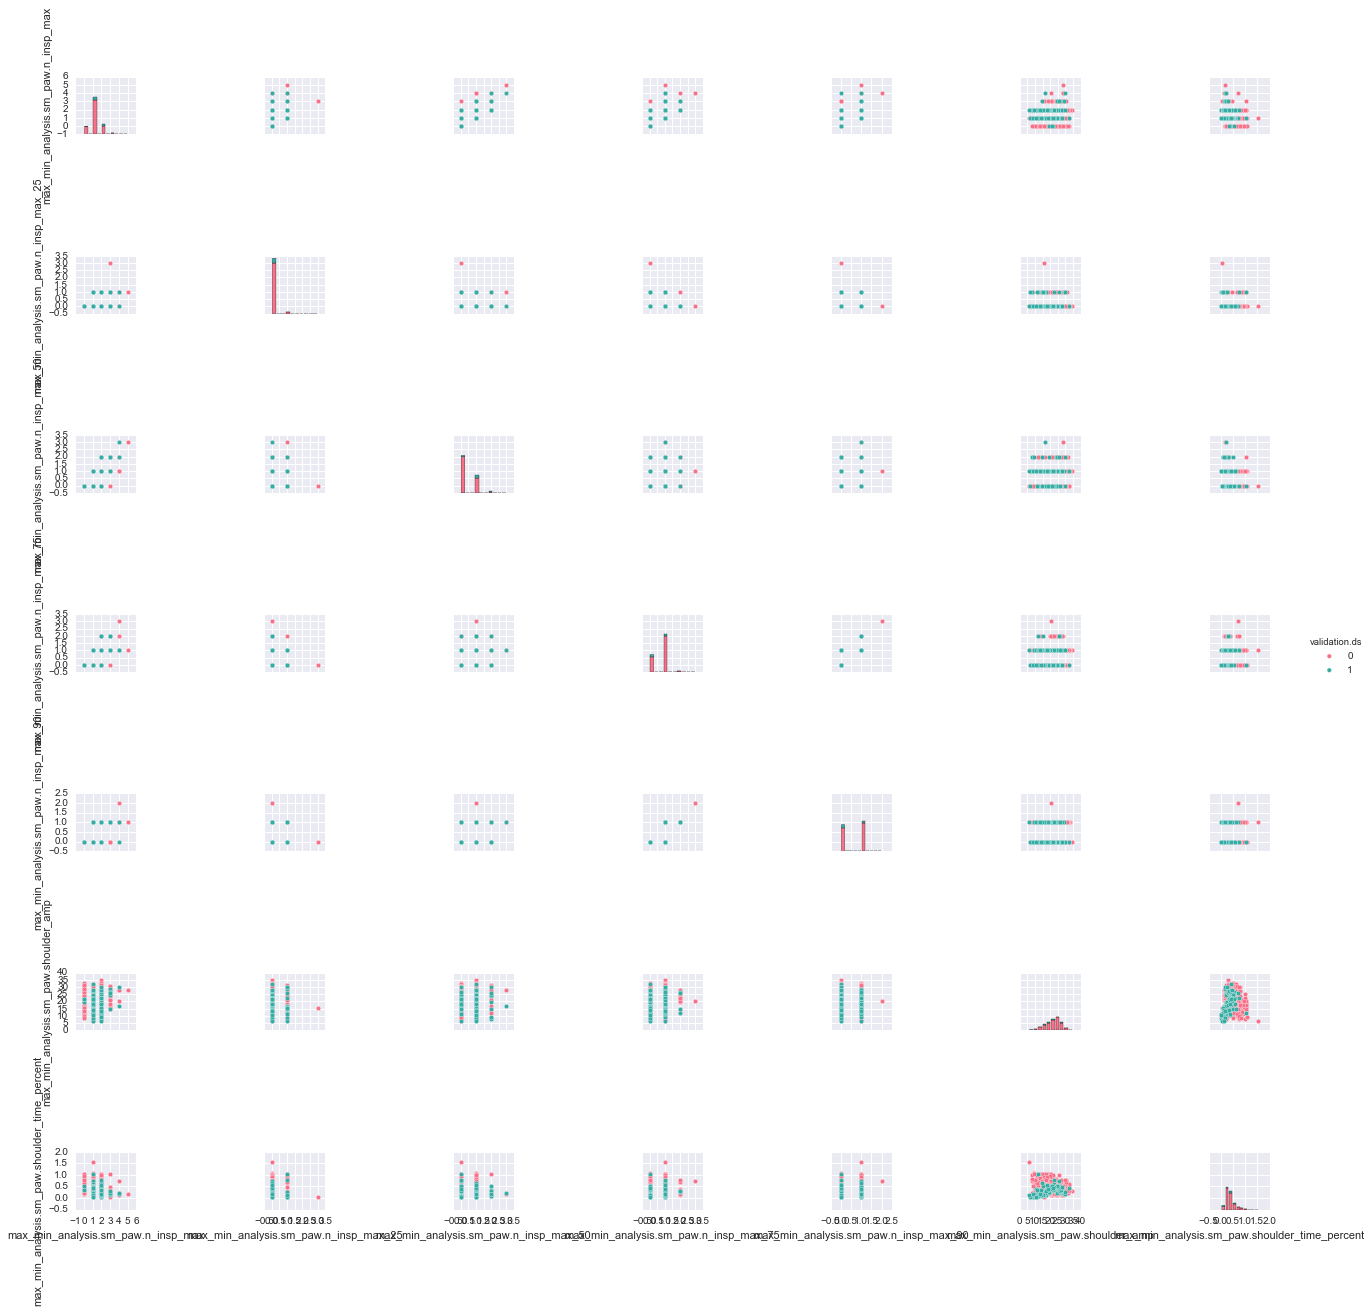

In [42]:
rows = col['pfl'][15:22]

sb.pairplot(df, hue='validation.ds', palette='husl', vars = rows)

In [ ]:
for stype in ['ds', 'pvt', 'pfl', 'ie', 'norm']:
    var = {'ds':ds_cols, 'pvt':pvt_cols, 'pfl':pfl_cols, 'ie':ie_cols, 'norm':norm_cols}
    joblib.dump(var[stype], 'c:\\Research_data\\VD_models\\'+stype+'\\'+stype+'_cols.pkl')

In [ ]:
norm_cols